# Modello finale

In [1]:
from analysis import MatchAnalysis #per il file con le medie
import util_strings as utils

In [2]:
import pickle
vectorizer = pickle.load(open(utils.vectorizer, 'rb'))
football_prediction = pickle.load(open(utils.classificator_FP, 'rb'))

Qui devo: 
* caricare il modello di football prediction, ottenere le etichette ed usarle nel dataset finale
* convertire ciascuna etichetta in 0 1 2 (verificare che non ci siano dati vuoti)
* allenare il modello su tutti i dati

In [3]:
ma = MatchAnalysis()
ma.read_matches(utils.merged_statistics)
ma.create_team_dataset()

import pandas as pd
completed = pd.read_csv(utils.completed_dataset, index_col=0)
old = completed.copy()
completed = completed[['description', 'prediction']]
len(completed)

1240

In [4]:
from my_tokenizer import MyTokenizer
mt = MyTokenizer(completed)
mt.clean_text()
vectorized = vectorizer.transform(mt.cleaned_corpus)

In [5]:
labels = football_prediction.predict(vectorized)

Ora queste etichette le metto nel dataset completo

In [6]:
completed = completed[completed.prediction != 'NAN']
index = 0

dict_result = {'N': 0, 'V': 1, 'P': 2}
for i, c in completed.iterrows():
    old.at[i, 'prediction'] = dict_result[labels[index]]
    index += 1

Ora che ho ottenuto le etichette, i valori nulli li sostituisco con -1, se no perdo le partite

In [7]:
old = old[old.prediction != 'NAN']

Ora devo cercare i nomi delle squadre nel dizionario in MatchAnalysis e sostituire ogni nome con il codice associato

In [8]:
for i, oo in old.iterrows():
    old.at[i, 'home'] = ma.get_id_by_name(oo.home)
    old.at[i, 'away'] = ma.get_id_by_name(oo.away)

Ora che ho ottenuto il dataset come deve essere ottenuto, posso fare la classificazione secondo Decision Tree o Random Forest

Normalizzazione dei dati

In [9]:
from sklearn import preprocessing

old.drop(columns=['description', 'date', 'season'], inplace=True)

In [10]:
old.to_csv(utils.final_dataset)

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


model = RandomForestClassifier()
X_train, X_test, y_train, y_test = train_test_split(old[[x for x in old.columns if x != 'result']], old['result'], test_size=0.2, shuffle=False) 


In [18]:
import sklearn.metrics as mtr

accuracy = 0

while(accuracy < 0.549):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    analysis = pd.DataFrame()
            
    report = mtr.classification_report(y_test, y_pred, output_dict=True, zero_division=0)

    if accuracy < report['accuracy']:
        accuracy = report['accuracy']
        print(accuracy)

analysis = {
        'Model': 'DecisionTree', 'Accuracy': report['accuracy'],
        'Avg Precision (macro)': report['macro avg']['precision'],
        'Avg Recall (macro)': report['macro avg']['recall'],
        'Avg F1-score (macro)': report['macro avg']['f1-score'],
        'Avg Precision (weighted)': report['weighted avg']['precision'],
        'Avg Recall (weighted)': report['weighted avg']['recall'],
        'Avg F1-score (weighted)': report['weighted avg']['f1-score']
    }

0.5413223140495868
0.5495867768595041


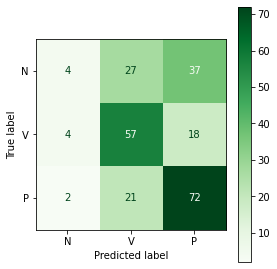

In [19]:
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

cm = mtr.confusion_matrix(y_test, y_pred)
d = mtr.ConfusionMatrixDisplay(cm, ['N', 'V', 'P'])
fig, ax = plt.subplots(figsize=(4,4))
d.plot(ax=ax, cmap='Greens')
plt.tight_layout()
plt.show()

In [20]:
import pickle

with open(utils.classificator, 'wb') as file:
    pickle.dump(model, file)